In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle

In [2]:

images_path = "../data/images"
masks_path = "../data/masks"
output_images_path = "../data/processed_data/images"
output_masks_path = "../data/processed_data/masks"

os.makedirs(output_images_path, exist_ok=True)
os.makedirs(output_masks_path, exist_ok=True)


TARGET_SIZE = (256, 256)

In [2]:

def preprocess_and_save(images_path, masks_path, output_images_path, output_masks_path):
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith('.jpg')]
    mask_files = [f for f in os.listdir(masks_path) if f.lower().endswith('_segmentation.png')]

    for img_file in image_files:
        try:
            
            mask_file = img_file.replace('.jpg', '_segmentation.png')

            if mask_file not in mask_files:
                print(f"Eşleşen maske bulunamadı, atlanıyor: {img_file}")
                continue

            img_path = os.path.join(images_path, img_file)
            mask_path = os.path.join(masks_path, mask_file)

            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if img is None or mask is None:
                print(f"Hata: {img_file} veya {mask_file} yüklenemedi!")
                continue

            img_resized = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)
            mask_resized = cv2.resize(mask, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)

            img_normalized = img_resized / 255.0

            np.save(os.path.join(output_images_path, img_file.replace('.jpg', '.npy')), img_normalized)
            np.save(os.path.join(output_masks_path, mask_file.replace('_segmentation.png', '.npy')), mask_resized)

        except Exception as e:
            print(f"Bir hata oluştu: {e}. Dosya atlanıyor: {img_file}, {mask_file}")

    print(f"Preprocessing tamamlandı. İşlenmiş veriler {output_images_path} ve {output_masks_path} klasörlerine kaydedildi.")


In [3]:
preprocess_and_save(images_path, masks_path, output_images_path, output_masks_path)

Preprocessing tamamlandı. İşlenmiş veriler ../data/processed_data/images ve ../data/processed_data/masks klasörlerine kaydedildi.


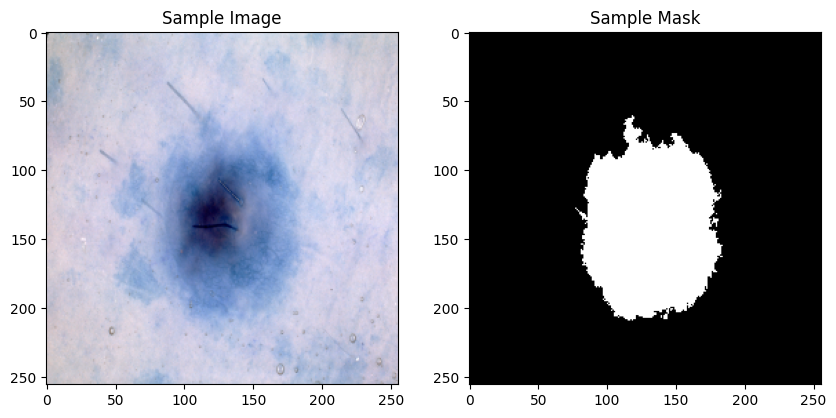

In [8]:

sample_img = np.load(os.path.join(output_images_path, os.listdir(output_images_path)[110]))
sample_mask = np.load(os.path.join(output_masks_path, os.listdir(output_masks_path)[110]))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Sample Image")
plt.imshow(sample_img)

plt.subplot(1,2,2)
plt.title("Sample Mask")
plt.imshow(sample_mask, cmap="gray")

plt.show()

In [10]:

processed_images_path = "../data/processed_data/images"
output_features_path = "../data/processed_data/features"

os.makedirs(output_features_path, exist_ok=True)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


2024-12-15 14:14:37.915003: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-12-15 14:14:37.915052: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-15 14:14:37.915063: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-15 14:14:37.915332: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-15 14:14:37.915354: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [11]:
def extract_features(img_path):
    """Görselden özellik haritası çıkarır."""
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array) 
    features = base_model.predict(img_array)
    return features

In [12]:

for img_file in os.listdir(processed_images_path):
    if img_file.endswith('.npy'):
        img_path = os.path.join(processed_images_path, img_file)
        img_array = np.load(img_path)

        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array * 255.0)

        features = base_model.predict(img_array)

        feature_path = os.path.join(output_features_path, img_file.replace('.npy', '_features.npy'))
        np.save(feature_path, features)

        print(f"Özellik çıkarıldı ve kaydedildi: {feature_path}")

print("Feature extraction işlemi tamamlandı.")

2024-12-15 14:15:09.597103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Özellik çıkarıldı ve kaydedildi: ../data/processed_data/features/ISIC_0000489_features.npy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Özellik çıkarıldı ve kaydedildi: ../data/processed_data/features/ISIC_0013393_features.npy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Özellik çıkarıldı ve kaydedildi: ../data/processed_data/features/ISIC_0012099_features.npy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Özellik çıkarıldı ve kaydedildi: ../data/processed_data/features/ISIC_0010856_features.npy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Özellik çıkarıldı ve kaydedildi: ../data/processed_data/features/ISIC_0000338_features.npy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Özellik çıkarıldı ve kaydedildi: ../data/processed_data/features/ISIC_0000476_features.npy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Özellik çıkarıldı ve kaydedildi: ../data/processed_data/features/ISIC_0014365_features.npy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Özellik çıkarıldı ve kaydedildi: ../data/processed_data/featu

In [3]:

def build_unet_resnet50(input_shape=(256, 256, 3)):
    
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    
    encoder_output = base_model.output
    skip1 = base_model.get_layer("conv1_relu").output      # 128x128
    skip2 = base_model.get_layer("conv2_block3_out").output  # 64x64
    skip3 = base_model.get_layer("conv3_block4_out").output  # 32x32
    skip4 = base_model.get_layer("conv4_block6_out").output  # 16x16

    
    x = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(encoder_output)  # 8x8 -> 16x16
    x = layers.Concatenate()([x, skip4])
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(x)  # 16x16 -> 32x32
    x = layers.Concatenate()([x, skip3])
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(x)  # 32x32 -> 64x64
    x = layers.Concatenate()([x, skip2])
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(x)  # 64x64 -> 128x128
    x = layers.Concatenate()([x, skip1])
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(x)  # 128x128 -> 256x256
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)

    
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

In [4]:

model = build_unet_resnet50()
model.summary()

2024-12-15 20:02:40.528024: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-12-15 20:02:40.528061: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-15 20:02:40.528066: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-15 20:02:40.528088: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-15 20:02:40.528104: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 40,996,673 (156.39 MB)

 Trainable params: 40,943,553 (156.19 MB)

 Non-trainable params: 53,120 (207.50 KB)

MODEL EĞİTİM AŞAMASI

In [5]:
feature_path = "../data/processed_data/features"
mask_path = "../data/processed_data/masks"

In [6]:

def load_data(feature_path, mask_path):
    X, Y = [], []
    feature_files = sorted([f for f in os.listdir(feature_path) if f.endswith('.npy')])
    mask_files = sorted([f for f in os.listdir(mask_path) if f.endswith('.npy')])

    for f_file, m_file in zip(feature_files, mask_files):
        features = np.load(os.path.join(feature_path, f_file))
        mask = np.load(os.path.join(mask_path, m_file))

        X.append(features)  
        Y.append(mask)      

    return np.array(X), np.array(Y)

In [7]:
X_train, Y_train = load_data(feature_path, mask_path)

In [8]:
print(f"Feature shape: {X_train.shape}, Mask shape: {Y_train.shape}")

Feature shape: (2594, 1, 8, 8, 2048), Mask shape: (2594, 256, 256)


In [9]:
X_train = np.squeeze(X_train)  

Y_train = np.expand_dims(Y_train, axis=-1) 

print(f"Feature shape: {X_train.shape}, Mask shape: {Y_train.shape}")


Feature shape: (2594, 8, 8, 2048), Mask shape: (2594, 256, 256, 1)


In [10]:
unique_values = np.unique(Y_train)
print(f"Maskelerdeki benzersiz değerler: {unique_values}")

Maskelerdeki benzersiz değerler: [  0 255]


In [11]:
if unique_values.max() > 1: 
    Y_train = Y_train / 255.0
    print("Maskeler normalize edildi: Değerler 0-1 aralığına getirildi.")

print(f"Yeni mask değerleri: {np.unique(Y_train)}")

Maskeler normalize edildi: Değerler 0-1 aralığına getirildi.
Yeni mask değerleri: [0. 1.]


In [26]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"])

callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint("../models/unet_resnet50_bestv2.keras", save_best_only=True)
]

In [12]:
def build_unet_decoder(input_shape=(8, 8, 2048)):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(inputs)  # 8x8 -> 16x16
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(x)  # 16x16 -> 32x32
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(x)  # 32x32 -> 64x64
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(x)  # 64x64 -> 128x128
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(x)  # 128x128 -> 256x256
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)

    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = build_unet_decoder()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8, 8, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 16, 16, 512)    │     4,194,816 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 64, 128)    │       131,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 128, 128, 64)   │        32,832 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 256, 256, 32)   │         8,224 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 256, 256, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,178,945 (42.64 MB)

 Trainable params: 11,178,945 (42.64 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model = build_unet_decoder()
model.summary()


model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"])

callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint("../models/unet_resnet50_bestv2.keras", save_best_only=True)
]

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 8, 8, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 16, 16, 512)    │     4,194,816 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 64, 64, 128)    │       131,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 128, 128, 64)   │        32,832 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_14             │ (None, 256, 256, 32)   │         8,224 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 256, 256, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,178,945 (42.64 MB)

 Trainable params: 11,178,945 (42.64 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:

history = model.fit(
    X_train, Y_train,
    validation_split=0.2,
    batch_size=8,
    epochs=30,
    callbacks=callbacks
)

model.save("../models/unet_resnet50_final.keras")
print("Model eğitimi tamamlandı ve kaydedildi.")

Epoch 1/30


2024-12-15 20:05:33.867042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


260/260 ━━━━━━━━━━━━━━━━━━━━ 53s 196ms/step - accuracy: 0.8131 - loss: 0.4031 - val_accuracy: 0.9081 - val_loss: 0.3136
Epoch 2/30
260/260 ━━━━━━━━━━━━━━━━━━━━ 51s 196ms/step - accuracy: 0.9318 - loss: 0.2278 - val_accuracy: 0.9131 - val_loss: 0.3001
Epoch 3/30
260/260 ━━━━━━━━━━━━━━━━━━━━ 50s 194ms/step - accuracy: 0.9418 - loss: 0.1760 - val_accuracy: 0.9162 - val_loss: 0.2244
Epoch 4/30
260/260 ━━━━━━━━━━━━━━━━━━━━ 50s 194ms/step - accuracy: 0.9498 - loss: 0.1217 - val_accuracy: 0.9184 - val_loss: 0.2204
Epoch 5/30
260/260 ━━━━━━━━━━━━━━━━━━━━ 50s 192ms/step - accuracy: 0.9538 - loss: 0.1114 - val_accuracy: 0.9229 - val_loss: 0.2046
Epoch 6/30
260/260 ━━━━━━━━━━━━━━━━━━━━ 50s 192ms/step - accuracy: 0.9627 - loss: 0.0900 - val_accuracy: 0.9241 - val_loss: 0.2099
Epoch 7/30
260/260 ━━━━━━━━━━━━━━━━━━━━ 50s 192ms/step - accuracy: 0.9701 - loss: 0.0708 - val_accuracy: 0.9220 - val_loss: 0.2437
Epoch 8/30
260/260 ━━━━━━━━━━━━━━━━━━━━ 51s 197ms/step - accuracy: 0.9733 - loss: 0.0632 - val

In [18]:
with open('../models/unet_resnet50_v2_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("Model history başarıyla kaydedildi.")

Model history başarıyla kaydedildi.
